 # Changes from Baseline Model
 
We want to improve the KNN-Hyperparameters
The baseline model hyperparameters are the default params from KNNRegressor

The HPT calculated:

``` json
{'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
```

``` python
KNeighborsRegressor(
             n_neighbors=5 -> 3
             weights="uniform" -> 'distance'
             algorithm="auto",
             leaf_size=30, -> 50
             p=2, -> 1
             metric="minkowski"
)

```

``` text
The hyperparameters you listed for a KNeighborsRegressor suggest a specific setup tailored to your dataset. Let’s break them down to determine their appropriateness:

leaf_size: 50

Controls the size of the leaf in the KDTree or BallTree used by the algorithm. A larger leaf size reduces the computational cost of tree queries but may lead to less precision in finding nearest neighbors. This value seems reasonable for a complex dataset, as smaller leaf sizes can increase computation time for large datasets.
metric: 'minkowski' and p: 1

The Minkowski metric is a generalization of the Euclidean and Manhattan distances. With p=1, it reduces to Manhattan distance. Manhattan distance tends to work better for high-dimensional datasets or cases where the features have varying scales. If your dataset fits this description, this choice is logical.
n_neighbors: 3

A lower value for n_neighbors means the model emphasizes the closest neighbors. This choice works well if your dataset has enough density and the relationships between points are highly localized. However, it may overfit on noisier or sparser datasets.
weights: 'distance'

Giving closer neighbors more weight (distance) is often beneficial when the relevance of a neighbor diminishes with distance. This is especially useful in non-uniform datasets where some points are far apart and less informative.
Suitability for Complex Datasets
Advantages:

The use of Manhattan distance (p=1) and distance-weighted neighbors helps in handling datasets with high dimensionality or non-uniform distributions.
n_neighbors=3 emphasizes local patterns, which could capture intricate relationships if the dataset is dense and relatively noise-free.
Potential Concerns:

A small n_neighbors may overfit, especially if the dataset is noisy or sparse.
If your features are not normalized, the Manhattan distance might disproportionately favor certain features. Ensure proper scaling of your dataset.
A leaf_size of 50 is generally good for computational performance, but you might experiment with slightly lower values if the model struggles with accuracy.

Recommendations:

Data Characteristics: If the dataset is very noisy or sparse, consider increasing n_neighbors slightly or testing additional metrics (e.g., chebyshev or euclidean) to see if they yield better results.
```

**Baseline model Score**

* RMSE: 1.9123
* Kaggle: 2.3830
 
**Model v3.0 Score**

* RMSE: 1.7917
* Kaggle: 2.3816

I think the model is overfitting, I will try to improve the model by changing the hyperparameters of the KNN model.

I will change in v3.1: 
* n_neighbors: 4
* weights='uniform'

# Model v3.0 - KNN-tuning

In [1]:
import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_base_model = HistGradientBoostingRegressor(max_iter=200, max_depth=5, learning_rate=0.1)
lasso_lars_ic_base_model = LassoLarsIC(criterion='bic', max_iter=10000)

#{'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
knn_base_model = KNeighborsRegressor(
    leaf_size=50,
    metric='minkowski',
    n_neighbors=3,
    p=1,
    weights='distance'
)

xgb_base_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=5, learning_rate=0.1)

estimators = [
    ('hgb', hgb_base_model),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_model),
    ('xgb', xgb_base_model),
]

baseline_model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=2)

21:06:51 - 21:06:51 - Start training
21:06:51 - 21:06:51 - Calculate performance for hgb
21:06:51 - 21:06:51 - Splitting the additional train data with ShuffleSplit
21:06:51 - 21:06:51 - Split 1 - Model: hgb
21:06:51 - 21:06:51 - Fitting the model
21:07:02 - 21:07:02 - Predicting
21:07:02 - 21:07:02 - Calculating scores
21:07:02 - 21:07:02 - R^2: 0.6169780779614347, RMSE: 2.028474323921719, MAE: 1.5080826901170945, MSE: 4.114708082809674
21:07:02 - 21:07:02 - Split 2 - Model: hgb
21:07:02 - 21:07:02 - Fitting the model
21:07:11 - 21:07:11 - Predicting
21:07:11 - 21:07:11 - Calculating scores
21:07:11 - 21:07:11 - R^2: 0.6139081611028374, RMSE: 2.039862417341566, MAE: 1.521009891629383, MSE: 4.161038681682577
21:07:11 - 21:07:11 - Split 3 - Model: hgb
21:07:11 - 21:07:11 - Fitting the model
21:07:20 - 21:07:20 - Predicting
21:07:20 - 21:07:20 - Calculating scores
21:07:20 - 21:07:20 - R^2: 0.6171640216271292, RMSE: 2.0106941454721508, MAE: 1.501761668398021, MSE: 4.042890946635983
21:07

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.4s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.3min remaining: 21.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.3min finished


21:38:46 - 21:38:46 - Predicting
21:40:46 - 21:40:46 - Calculating scores
21:42:45 - 21:42:45 - R^2: 0.701087205548097, RMSE: 1.791966768551545, MAE: 1.3020640720669172, MSE: 3.2111448995930667
21:42:45 - 21:42:45 - Split 2 - Model: stacking_regressor
21:42:45 - 21:42:45 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 24.2min remaining: 36.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.3min finished


22:07:25 - 22:07:25 - Predicting
22:11:17 - 22:11:17 - Calculating scores
22:13:30 - 22:13:30 - R^2: 0.6974199649644914, RMSE: 1.8058251619743961, MAE: 1.3175733895427604, MSE: 3.261004515619854
22:13:30 - 22:13:30 - Split 3 - Model: stacking_regressor
22:13:30 - 22:13:30 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.8s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.8s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 18.9min remaining: 28.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.9min finished


22:32:48 - 22:32:48 - Predicting
22:34:14 - 22:34:14 - Calculating scores
22:35:39 - 22:35:39 - R^2: 0.6984123609788261, RMSE: 1.7846226859916285, MAE: 1.300716231917059, MSE: 3.184878131355975
22:35:39 - 22:35:39 - Split 4 - Model: stacking_regressor
22:35:40 - 22:35:40 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.0s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.8s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.3min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.3min finished


22:47:18 - 22:47:18 - Predicting
22:48:44 - 22:48:44 - Calculating scores
22:50:11 - 22:50:11 - R^2: 0.6971608669350893, RMSE: 1.8091787545923244, MAE: 1.3195577481512764, MSE: 3.273127766068234
22:50:11 - 22:50:11 - Split 5 - Model: stacking_regressor
22:50:11 - 22:50:11 - Fitting the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.0s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.3s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.3min remaining: 17.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min finished


23:01:51 - 23:01:51 - Predicting
23:03:21 - 23:03:21 - Calculating scores
23:04:47 - 23:04:47 - R^2: 0.6931871787032624, RMSE: 1.7979504065149807, MAE: 1.3118804543784484, MSE: 3.2326256642873843
23:04:47 - 23:04:47 - Training finished


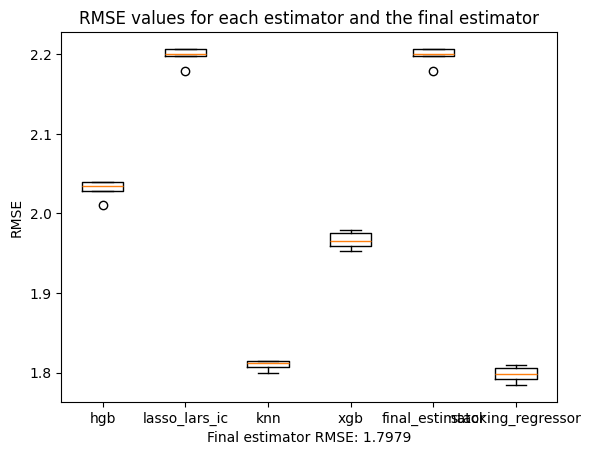

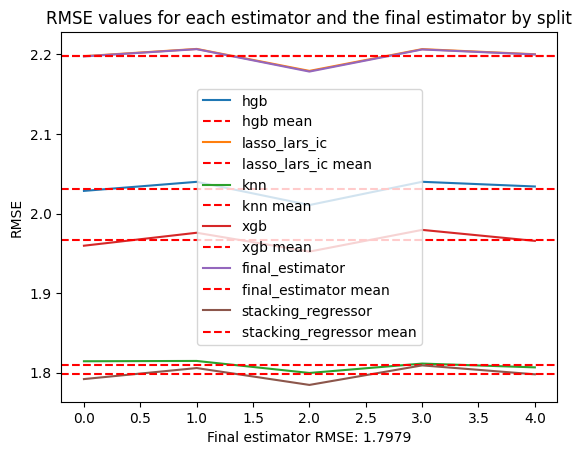

In [7]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v3.0-KNN-tuning'

save_model(baseline_model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(baseline_model, X_train, y_train, X_additional_train, y_additional_train)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [10]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))

X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']
X_test = pipeline.transform(test_data)

baseline_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.9s remaining:   29.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   55.5s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.0min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.0min finished


StackingRegressor(estimators=[('hgb',
                               HistGradientBoostingRegressor(max_depth=5,
                                                             max_iter=200)),
                              ('lasso_lars_ic',
                               LassoLarsIC(criterion='bic', max_iter=10000)),
                              ('knn',
                               KNeighborsRegressor(leaf_size=50, n_neighbors=3,
                                                   p=1, weights='distance')),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsam...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=Ridge(alpha=0.1), n_jobs=-1, verbose=2)

In [11]:
y_pred = baseline_model.predict(X_test)
test_data['bg+1:00'] = y_pred

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.160133
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,5.603416
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.066545
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.029734
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.660453


In [12]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,9.160133
p01_8460,5.603416
p01_8461,8.066545
p01_8462,11.029734
p01_8463,6.660453
...,...
p24_256,6.090395
p24_257,10.427129
p24_258,6.473545


In [13]:
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')